## 1. Introduction

This notebook implements **Part 2: Analysis and Modeling** of the DAT204M HW2 project.

It connects directly to the Supabase cloud database created in Part 1, retrieves data, and performs:
- Exploratory Data Analysis (EDA)
- Data visualization
- Simple Machine Learning modeling (Track A)

The objective is to build a predictive model that estimates **CO₂ emissions per capita** using energy, economic, and demographic indicators.

This workflow highlights the end-to-end integration of cloud data persistence and data-driven analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
from supabase import create_client

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

load_dotenv()

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_SERVICE_ROLE_KEY") or os.getenv("SUPABASE_ANON_KEY")
assert SUPABASE_URL and SUPABASE_KEY, "Missing SUPABASE_URL or Supabase key in .env"

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✅ Supabase client ready")


✅ Supabase client ready


In [2]:
TABLE_NAME = "brn_indicators"

# Target and candidate features for Track A
TARGET = "co2_per_capita_tco2e_excl_lulucf"
FEATURES = [
    "energy_use_kg_oe_per_capita",
    "gdp_current_usd",
    "population_total",
    "urban_pop_pct",
    "renewable_energy_consumption_pct",
]

# Optional filters if you want a specific country or year range
FILTER_COUNTRY = None            # e.g., "BRN" or None for all available
YEAR_MIN, YEAR_MAX = None, None  # e.g., 1990, 2022 or None

## 2. Data Retrieval from Supabase

We query the same `brn_indicators` table uploaded in Part 1.

Instead of reading from a local CSV, this notebook retrieves data directly from Supabase using the REST API (`supabase-py` client).

This demonstrates:
- Cloud-based reproducibility.
- Separation between data storage and analysis environments.
- Ability to re-run analysis from any machine with credentials.

In [3]:
# Build the query
q = supabase.table(TABLE_NAME).select("*")

if FILTER_COUNTRY:
    q = q.eq("country", FILTER_COUNTRY)
if YEAR_MIN is not None:
    q = q.gte("year", YEAR_MIN)
if YEAR_MAX is not None:
    q = q.lte("year", YEAR_MAX)

resp = q.execute()
df = pd.DataFrame(resp.data)

print(df.shape)
df.sort_values(["country", "year"]).head()

(350, 11)


,country,year,co2_per_capita_tco2e_excl_lulucf,co2_total_mtco2e_excl_lulucf,energy_use_kg_oe_per_capita,gdp_current_usd,population_total,renewable_electricity_pct,renewable_energy_consumption_pct,urban_pop_pct,missing_indicator_count
295,BRN,1990,16.843458,4.3000,6766.202658,6.039881e+09,255292,0.0,0.7,66.438,0
296,BRN,1991,18.696020,4.9095,7438.262038,6.284497e+09,262596,0.0,0.4,66.585,0
297,BRN,1992,19.868514,5.3613,7783.232736,6.327966e+09,269839,0.0,0.2,67.078,0
298,BRN,1993,19.535619,5.4108,7299.532663,6.203340e+09,276971,0.0,0.0,67.604,0
299,BRN,1994,19.338170,5.4938,6603.066579,6.467783e+09,284091,0.0,0.0,68.126,0


In [4]:
required_cols = ["country", "year", TARGET] + FEATURES
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing columns in table: {missing}"

# Ensure correct types
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
for col in FEATURES + [TARGET]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep rows that have the target
df = df.dropna(subset=[TARGET]).copy()

# Brief info
display(df[["country", "year", TARGET] + FEATURES].head())
print(df[["country", "year"]].drop_duplicates().shape[0], "country-year rows")

,country,year,co2_per_capita_tco2e_excl_lulucf,energy_use_kg_oe_per_capita,gdp_current_usd,population_total,urban_pop_pct,renewable_energy_consumption_pct
0,BRN,2023,21.170326,9537.051561,1.509508e+10,458949,79.149,0.0
1,BRN,2024,21.170326,9537.051561,1.546313e+10,462721,79.439,0.0
2,IDN,1990,0.881620,461.478750,1.061407e+11,183501098,30.584,59.2
3,IDN,1991,0.935142,477.034665,1.166220e+11,186778238,31.613,58.4
4,IDN,1992,0.960602,489.759547,1.280270e+11,190043744,32.703,57.5


350 country-year rows


In [5]:
display(df[[TARGET] + FEATURES].describe().T)

missing_counts = df[[TARGET] + FEATURES].isna().sum().sort_values(ascending=False)
print("Missing values:\n", missing_counts)

,count,mean,std,min,25%,50%,75%,max
co2_per_capita_tco2e_excl_lulucf,350.0,4.545977e+00,5.901219e+00,5.861892e-02,6.164060e-01,1.796210e+00,7.090627e+00,2.362537e+01
energy_use_kg_oe_per_capita,350.0,1.987937e+03,2.500569e+03,2.588368e+02,4.077525e+02,6.723931e+02,2.507310e+03,9.699300e+03
gdp_current_usd,350.0,1.709432e+11,2.385773e+11,8.655599e+08,1.344133e+10,7.896367e+10,2.570312e+11,1.396300e+12
population_total,350.0,5.764443e+07,6.861710e+07,2.552920e+05,6.079419e+06,3.768746e+07,7.566818e+07,2.834879e+08
urban_pop_pct,350.0,4.787375e+01,2.464989e+01,1.543700e+01,2.836525e+01,4.452700e+01,6.659175e+01,1.000000e+02
renewable_energy_consumption_pct,350.0,3.618514e+01,2.963801e+01,0.000000e+00,4.425000e+00,3.210000e+01,6.025000e+01,9.110000e+01


Missing values:
 co2_per_capita_tco2e_excl_lulucf    0
energy_use_kg_oe_per_capita         0
gdp_current_usd                     0
population_total                    0
urban_pop_pct                       0
renewable_energy_consumption_pct    0
dtype: int64


## 3. Exploratory Data Analysis (EDA)

EDA helps us understand relationships among key variables such as:
- CO₂ emissions per capita
- Energy consumption per capita
- GDP (current USD)
- Urban population percentage
- Renewable energy share

We use `pandas`, `matplotlib`, and `seaborn` to:
- Summarize basic statistics.
- Plot distributions and time series.
- Visualize correlations among features.

This step helps guide feature selection and verify data consistency.

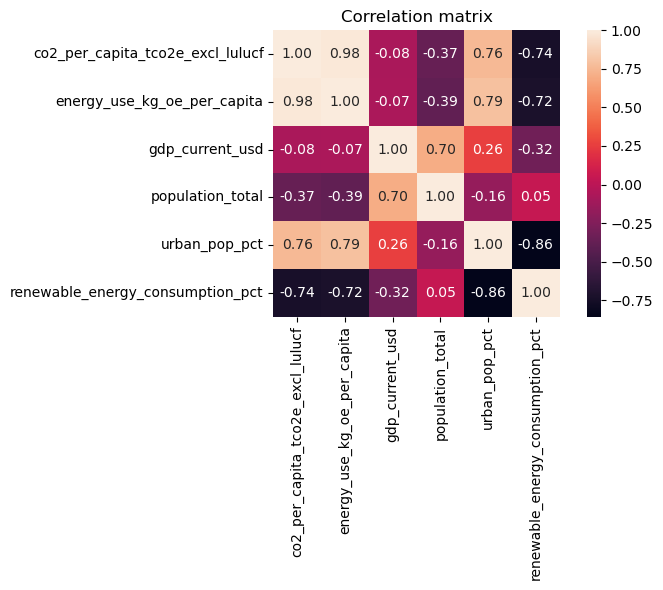

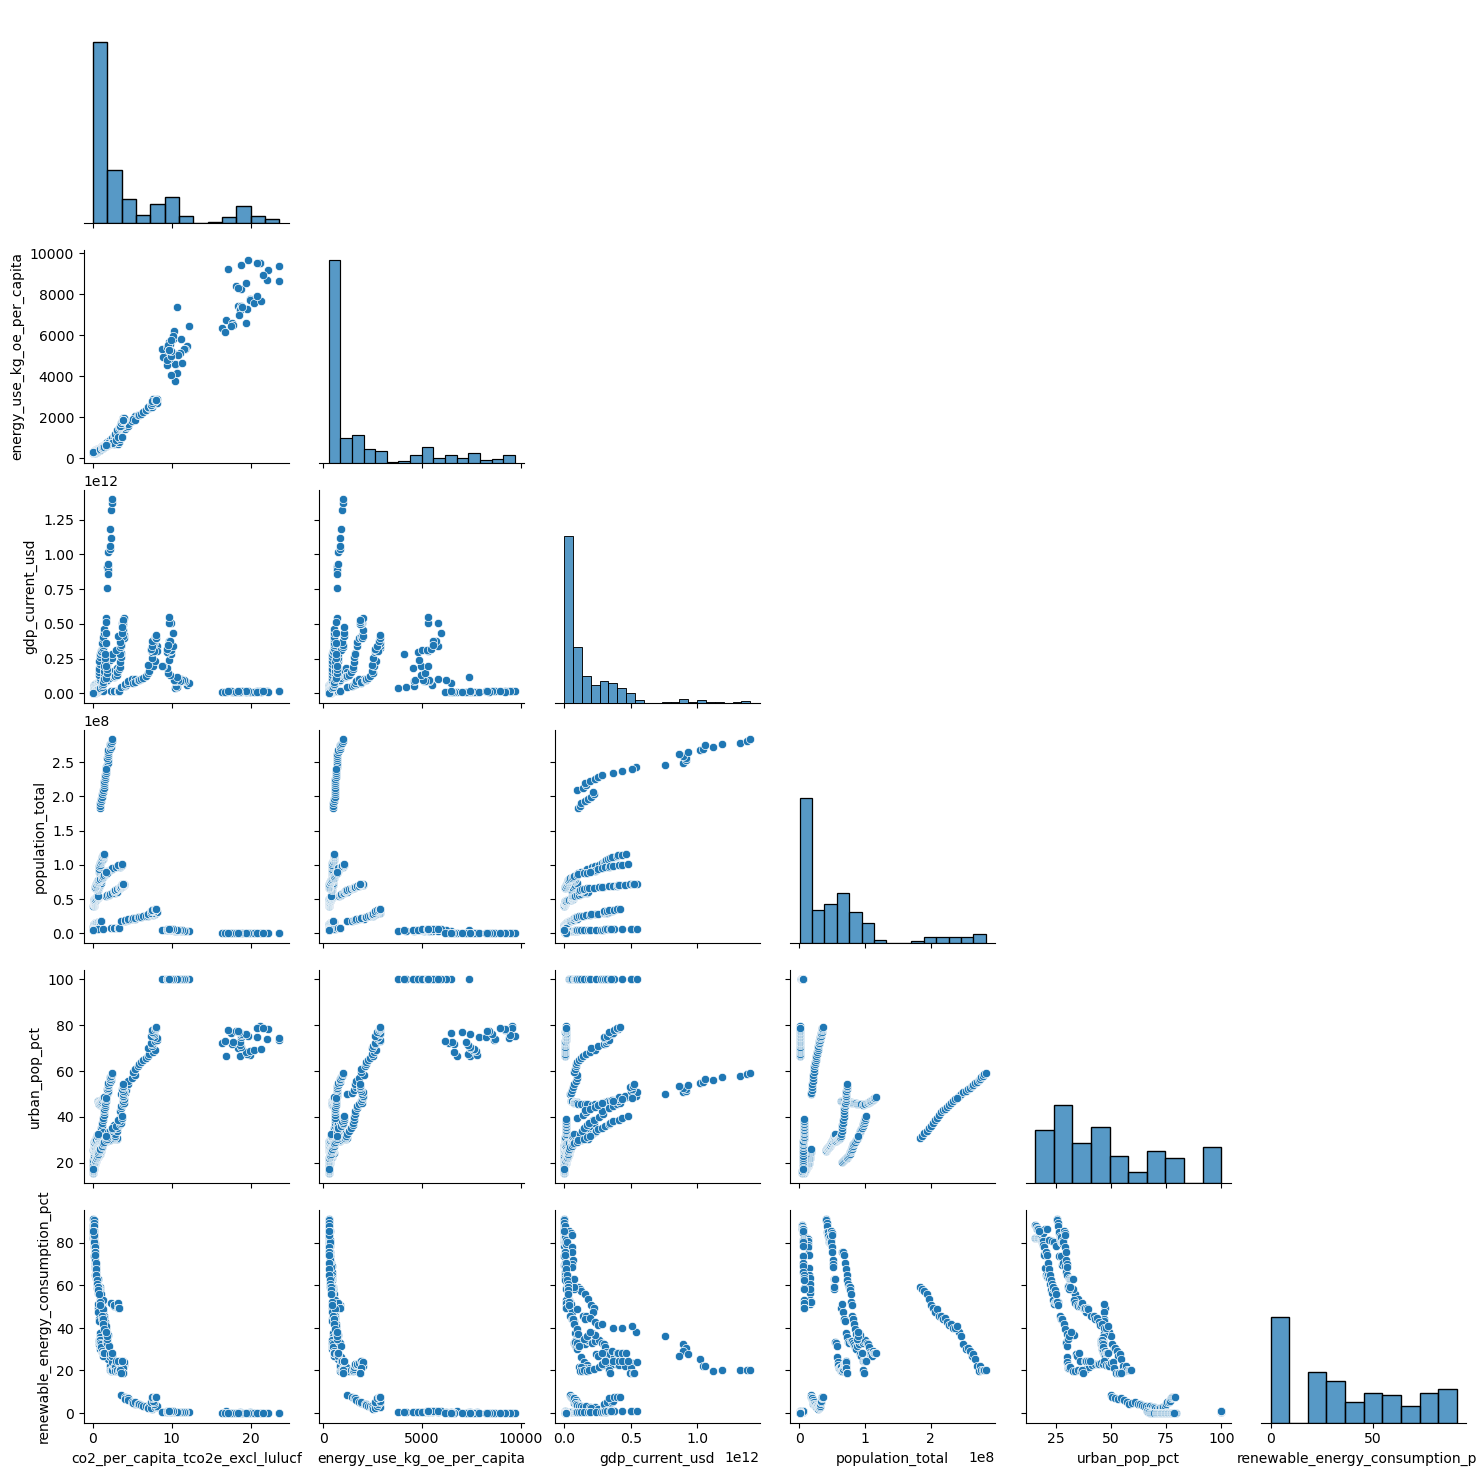

In [6]:
num_cols = [TARGET] + [c for c in FEATURES if c in df.columns]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

# Pairplot can be slow on very large data; safe for your dataset sizes
sns.pairplot(df[num_cols].dropna(), corner=True, diag_kind="hist")
plt.show()

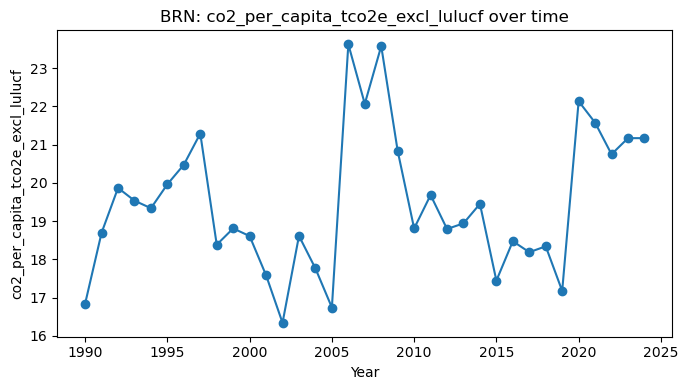

In [7]:
if "country" in df.columns:
    sample_country = FILTER_COUNTRY or df["country"].value_counts().index[0]
    ts = df[df["country"] == sample_country].sort_values("year")
    plt.figure(figsize=(7,4))
    plt.plot(ts["year"], ts[TARGET], marker="o")
    plt.title(f"{sample_country}: {TARGET} over time")
    plt.xlabel("Year"); plt.ylabel(TARGET)
    plt.tight_layout(); plt.show()

In [8]:
model_df = df[["country", "year", TARGET] + FEATURES].copy()

# Optionally drop rows with missing features
model_df = model_df.dropna(subset=FEATURES).copy()

print(model_df.shape)
display(model_df.head())

(350, 8)


,country,year,co2_per_capita_tco2e_excl_lulucf,energy_use_kg_oe_per_capita,gdp_current_usd,population_total,urban_pop_pct,renewable_energy_consumption_pct
0,BRN,2023,21.170326,9537.051561,1.509508e+10,458949,79.149,0.0
1,BRN,2024,21.170326,9537.051561,1.546313e+10,462721,79.439,0.0
2,IDN,1990,0.881620,461.478750,1.061407e+11,183501098,30.584,59.2
3,IDN,1991,0.935142,477.034665,1.166220e+11,186778238,31.613,58.4
4,IDN,1992,0.960602,489.759547,1.280270e+11,190043744,32.703,57.5


In [9]:
X = model_df[FEATURES].values
y = model_df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("Train size:", X_train_s.shape, "Test size:", X_test_s.shape)


Train size: (262, 5) Test size: (88, 5)


In [10]:
# Train the linear regression model
linreg = LinearRegression()
linreg.fit(X_train_s, y_train)

# Predictions
y_tr_pred = linreg.predict(X_train_s)
y_te_pred = linreg.predict(X_test_s)

# Metrics
r2_tr = r2_score(y_train, y_tr_pred)
r2_te = r2_score(y_test, y_te_pred)
rmse_tr = root_mean_squared_error(y_train, y_tr_pred)
rmse_te = root_mean_squared_error(y_test, y_te_pred)

# Display results
print(f"R² train: {r2_tr:.3f} | R² test: {r2_te:.3f}")
print(f"RMSE train: {rmse_tr:.3f} | RMSE test: {rmse_te:.3f}")

R² train: 0.967 | R² test: 0.978
RMSE train: 1.075 | RMSE test: 0.848


,coef
energy_use_kg_oe_per_capita,5.805794
population_total,0.152757
gdp_current_usd,-0.246619
urban_pop_pct,-1.001615
renewable_energy_consumption_pct,-1.159796


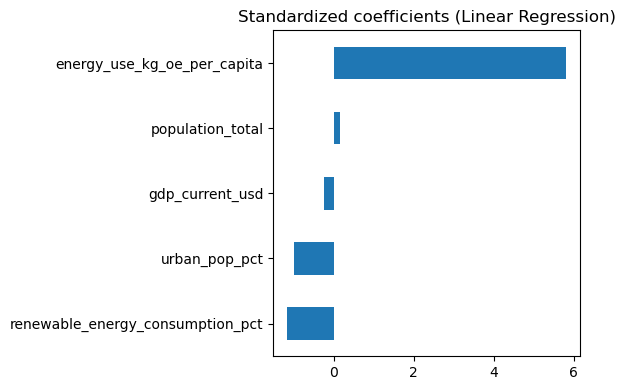

Intercept: 4.781563723724934


In [11]:
coef = pd.Series(linreg.coef_, index=FEATURES).sort_values(ascending=False)
display(coef.to_frame("coef"))

plt.figure(figsize=(6,4))
coef.sort_values().plot(kind="barh")
plt.title("Standardized coefficients (Linear Regression)")
plt.tight_layout()
plt.show()

print("Intercept:", linreg.intercept_)

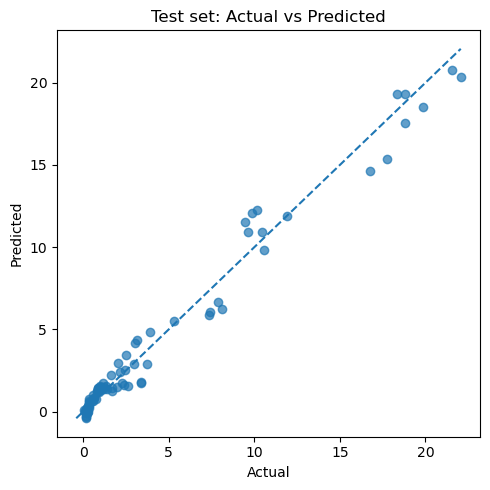

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_te_pred, alpha=0.7)
low, high = min(y_test.min(), y_te_pred.min()), max(y_test.max(), y_te_pred.max())
plt.plot([low, high], [low, high], linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Test set: Actual vs Predicted")
plt.tight_layout()
plt.show()

In [13]:
# Baseline: always predict the mean of y_train
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

# Evaluate baseline performance
r2_base = r2_score(y_test, baseline_pred)
rmse_base = root_mean_squared_error(y_test, baseline_pred)

# Compare to your model
r2_improvement = r2_te - r2_base

print(f"Baseline R²: {r2_base:.3f} | Baseline RMSE: {rmse_base:.3f}")
print(f"Linear Regression improves R² by {r2_improvement:.3f}")

Baseline R²: -0.027 | Baseline RMSE: 5.770
Linear Regression improves R² by 1.005


### Summary
- Objective: Predict `{TARGET}` using {len(FEATURES)} features from the cloud database.
- Train R^2: {r2_tr:.3f}, Test R^2: {r2_te:.3f}
- Train RMSE: {rmse_tr:.3f}, Test RMSE: {rmse_te:.3f}

### Interpretation
- Standardized coefficients suggest the strongest drivers of `{TARGET}` are:
{chr(10).join([f"  • {name}: {value:.3f}" for name, value in coef.items()])}

### Notes and limitations
- Results depend on available rows after dropping missing features.
- Linear model is easy to interpret but may miss nonlinear effects.
- Data is loaded directly from Supabase, not from local CSV, which satisfies Part 2.

### Next steps
- Try a tree-based model (DecisionTreeRegressor or RandomForestRegressor).
- Add interaction terms or log-transform skewed features.
- Expand to multi-country panel to increase sample size.

In [14]:
# Train the linear regression model
linreg = LinearRegression()
linreg.fit(X_train_s, y_train)

# Predictions
y_tr_pred = linreg.predict(X_train_s)
y_te_pred = linreg.predict(X_test_s)

# Metrics
r2_tr = r2_score(y_train, y_tr_pred)
r2_te = r2_score(y_test, y_te_pred)
rmse_tr = root_mean_squared_error(y_train, y_tr_pred)
rmse_te = root_mean_squared_error(y_test, y_te_pred)

# Display results
print(f"R² train: {r2_tr:.3f} | R² test: {r2_te:.3f}")
print(f"RMSE train: {rmse_tr:.3f} | RMSE test: {rmse_te:.3f}")

R² train: 0.967 | R² test: 0.978
RMSE train: 1.075 | RMSE test: 0.848
